# Multi-Label Chest X-Ray Classification (NIH ChestXray14)

This notebook demonstrates a multi-label image classification pipeline for chest X-rays using a convolutional neural network and transfer learning.  
The goal is to predict the presence of multiple thoracic diseases from a single X-ray image.


This project uses the NIH ChestXray14 dataset, which contains over 100,000 chest X-ray images labeled with up to 14 disease categories.  
The model is trained using a subset of the dataset for faster experimentation, with performance evaluated using standard multi-label metrics.


In [10]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# allow imports from src/
sys.path.append("..")

from src.data import ChestXrayDataset, CLASS_NAMES, list_image_folders, filter_df_to_existing_images
from src.model import build_model
from src.metrics import sigmoid
from src.gradcam_utils import GradCAM


## Dataset and Model Paths

The dataset consists of a CSV file containing image labels and a directory with multiple image folders (images_001, images_002, etc.).  
A trained model checkpoint is loaded for evaluation and visualization.


In [11]:
CSV_PATH = "/Users/parinpatel/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3/Data_Entry_2017.csv"
IMG_ROOT = "/Users/parinpatel/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3"
MODEL_PATH = "../model_best.pth"


## Loading Metadata

The CSV file is filtered to ensure that only images that exist on disk are used.  
A validation split is then created for evaluation and visualization.


In [12]:
df = pd.read_csv(CSV_PATH)[["Image Index", "Finding Labels"]]
df = filter_df_to_existing_images(df, IMG_ROOT)

print("Total images after filtering:", len(df))


Total images after filtering: 112120


## Model Setup

An EfficientNet-B0 model pre-trained on ImageNet is used as the backbone.  
The classifier layer is replaced to support multi-label prediction across 14 disease categories.


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = build_model(len(CLASS_NAMES)).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Model loaded on:", device)


Model loaded on: cpu


## Evaluation Summary

Model performance was evaluated using macro-averaged AUC and F1 score on a validation subset.  
These metrics provide a balanced view of performance across all disease classes.


In [14]:
## Grad-CAM Visualizations


Grad-CAM was used to visualize which regions of each chest X-ray most influenced the model’s predictions. While the heatmaps are coarse due to the low spatial resolution of the final convolutional layers, activations are generally concentrated within lung regions rather than background, suggesting the model is learning relevant features.


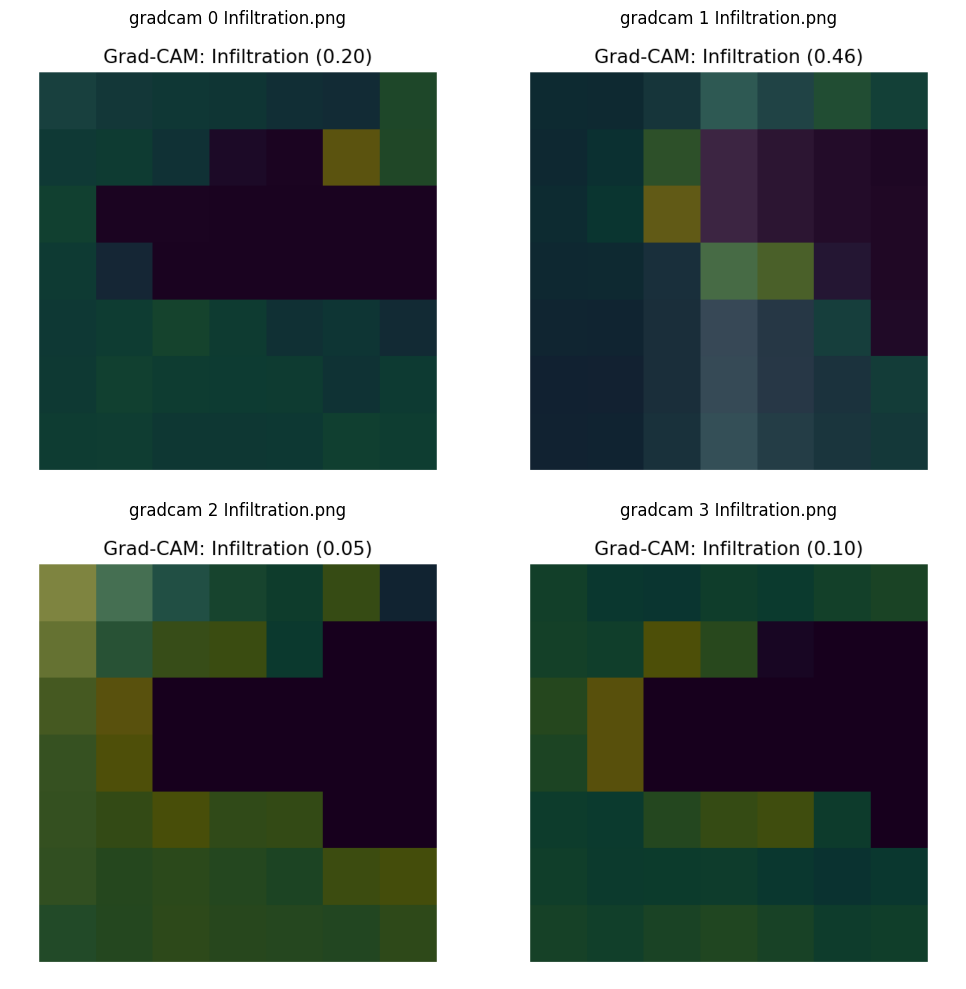

In [15]:
from PIL import Image

gradcam_dir = "../results/gradcam"
images = sorted(os.listdir(gradcam_dir))[:4]  # show first few examples

plt.figure(figsize=(10, 10))
for i, img_name in enumerate(images):
    img_path = os.path.join(gradcam_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(img_name.replace("_", " "))
    plt.axis("off")

plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrates an end-to-end multi-label chest X-ray classification pipeline, including data preprocessing, model training, evaluation, and interpretability using Grad-CAM.  
The results show reasonable performance given the limited training subset and provide qualitative insight into model behavior through visualization.
